# Look at the classified genes with violinplots in Shalek2013

What single cell paper would be complete without violinplots?!? 

Now we're going to look at the top genes by plotting each of them, separated by the two groups

In [4]:
# Alphabetical order is standard
# We're doing "import superlongname as abbrev" for our laziness - this way we don't have to type out the whole thing each time.

# Python plotting library
import matplotlib.pyplot as plt

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# Statistical plotting library we'll use
import seaborn as sns
sns.set(style='whitegrid')

# Label processing
from sklearn import preprocessing

# Matrix decomposition
from sklearn.decomposition import PCA, FastICA

# Classification
from sklearn.svm import SVC

# This is necessary to show the plotted figures inside the notebook -- "inline" with the notebook cells
%matplotlib inline


## Read in the Shalek2013 data and classify it

In [5]:
metadata = pd.read_csv('../data/shalek2013/metadata.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression = pd.read_csv('../data/shalek2013/expression.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression_feature = pd.read_csv('../data/shalek2013/expression_feature.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)

# creating new column indicating color
metadata['color'] = metadata['maturity'].map(
    lambda x: 'MediumTurquoise' if x == 'immature' else 'Teal')
metadata.loc[metadata['pooled'], 'color'] = 'black'

# Create a column indicating both maturity and pooled for coloring with seaborn, e.g. sns.pairplot
metadata['group'] = metadata['maturity']
metadata.loc[metadata['pooled'], 'group'] = 'pooled'

# Create a palette and ordering for using with sns.pairplot
palette = ['MediumTurquoise', 'Teal', 'black']
order = ['immature', 'mature', 'pooled']


singles_ids = [x for x in expression.index if x.startswith('S')]
singles = expression.loc[singles_ids]

# Use only the genes that are substantially expressed in single cells

singles = singles.loc[:, (singles > 1).sum() >= 3]
singles.shape

# Now because computers only understand numbers, we'll convert the 
# category label of "mature" and "immature" into integers to a using a 
# `LabelEncoder`. Let's look at that column again, only for mature cells:

singles_maturity = metadata.loc[singles.index, 'maturity']

# Instantiate the encoder
encoder = preprocessing.LabelEncoder()

# Get number of categories and transform "mature"/"immature" to numbers
target = encoder.fit_transform(singles_maturity)

## Run the classifier!!

# Yay so now we can run a classifier!


classifier = SVC(kernel='linear')
classifier.fit(singles, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's create that `coefficients` series again which we'll use extensively.

In [6]:
coefficients = pd.Series(classifier.coef_.flat, index=singles.columns)
coefficients.head()

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/pandas/types/dtypes.py:127: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


NPL        -1.387786e-04
QK          1.543810e-04
AK163153    3.543145e-04
AGPAT4     -4.594230e-04
IGF2R       2.282964e-07
dtype: float64

## Violinplots!!

To make violinplots, let's first get smaller subset of our data to plot with.

In [7]:
below_stringent_cutoff = coefficients[coefficients < (coefficients.mean() - 3*coefficients.std())]
print(below_stringent_cutoff.shape)
below_stringent_cutoff.head()

(38,)


MYO1F    -0.000872
TNF      -0.000727
TREM2    -0.000786
FCGR2B   -0.000935
FCGR3    -0.000796
dtype: float64

And get just the genes from this cutoff

In [8]:
singles_below_stringent_cutoff = singles[below_stringent_cutoff.index]
print(singles_below_stringent_cutoff.shape)
singles_below_stringent_cutoff.head()

(18, 38)


,MYO1F,TNF,TREM2,FCGR2B,FCGR3,CD14,LIPA,IL1RN,PTGS1,AK042010,...,TCN2,LCP2,GAS7,CD68,LGALS9,GRN,IRG1,DAB2,LY6E,SLC25A17
S1,5.533537,7.516027,6.097865,6.503564,7.455563,7.924038,7.024189,8.134646,5.706133,5.735305,...,5.537479,6.423808,4.697265,7.453081,6.742298,7.500705,7.528378,5.897524,7.365689,4.637105
S2,6.088362,7.888688,6.193491,5.633138,6.968547,8.808312,5.584063,8.394242,6.948140,0.504229,...,5.321767,6.673086,6.244676,7.406143,6.089116,6.295191,8.452670,2.170954,7.474858,0.167093
S3,5.719140,7.034520,5.047416,7.477194,7.768496,8.017196,6.256781,5.115908,6.476675,5.728017,...,5.414372,6.955875,4.226536,7.485032,4.965707,5.276256,7.805923,5.272320,6.931039,4.864592
S4,5.678220,7.786518,5.129028,6.557769,6.645002,8.801066,6.517728,8.585620,4.835453,4.984688,...,5.475241,5.809869,4.721721,7.505658,5.401650,6.923186,8.917935,5.931883,0.940697,5.677181
S5,5.383171,6.914768,5.903853,6.774883,8.070009,8.755324,6.875709,7.445529,2.057641,5.433711,...,5.198257,6.600846,4.818863,7.477363,6.775298,7.050431,8.825223,5.481812,6.754792,4.765044


We **could** plot all of these genes right now but that doesn't tell us about how these genes are different between the groups. We'll need to make this into *tidy data* for that.

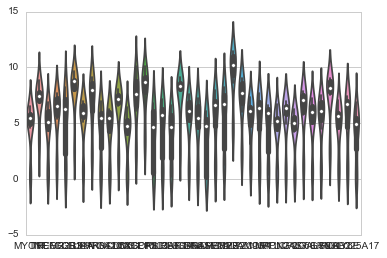

In [14]:
sns.violinplot(data=singles_below_stringent_cutoff)
#does not include classifier info of diff maturity levels etc
#need to do data munching
#need to make into tidy data frame

## Tidy data

Now we need to make this data into a [tidy](http://vita.had.co.nz/papers/tidy-data.pdf) dataframe, where every row is a single observation of a gene and a sample. We will do this with two commands `.unstack()` and `.reset_index()`:

In [15]:
singles_below_stringent_cutoff_unstacked = singles_below_stringent_cutoff.unstack() #awesome!!!
print(singles_below_stringent_cutoff_unstacked.shape)
singles_below_stringent_cutoff_unstacked.head()
#Series as no lines dividing into table - v long tall list
# singles_below_stringent_cutoff_unstacked.tail()

(684,)


MYO1F  S1    5.533537
       S2    6.088362
       S3    5.719140
       S4    5.678220
       S5    5.383171
dtype: float64

Now we'll "reset" the index, meaning, move all the row names into the dataframe instead of as the row labels:

In [16]:
singles_below_stringent_cutoff_reset_index = singles_below_stringent_cutoff_unstacked.reset_index()
print(singles_below_stringent_cutoff_reset_index.shape)
singles_below_stringent_cutoff_reset_index.head()
#with column of multiple unique values - can use groupby!! Can have multi level row name!!!
#reset_index makes every column in series an actual column in dataframe - level_0 e.g. gene ID, level_1 e.g. cell type

(684, 3)


,level_0,level_1,0
0,MYO1F,S1,5.533537
1,MYO1F,S2,6.088362
2,MYO1F,S3,5.719140
3,MYO1F,S4,5.678220
4,MYO1F,S5,5.383171


Let's rename the columns to something more meaningful

In [17]:
singles_below_stringent_cutoff_tidy = singles_below_stringent_cutoff_reset_index.rename(
    columns={'level_0': 'gene_id', 'level_1': 'sample_id', 0:'log2(TPM+1)'}) #renamed data frame col names
print(singles_below_stringent_cutoff_tidy.shape)
singles_below_stringent_cutoff_tidy.head()

(684, 3)


,gene_id,sample_id,log2(TPM+1)
0,MYO1F,S1,5.533537
1,MYO1F,S2,6.088362
2,MYO1F,S3,5.719140
3,MYO1F,S4,5.678220
4,MYO1F,S5,5.383171


Now we'll want to add our metadata so we have the information for plotting

In [18]:
singles_below_stringent_cutoff_tidy_metadata = singles_below_stringent_cutoff_tidy.join(metadata, on='sample_id') ## :)
print(singles_below_stringent_cutoff_tidy_metadata.shape) # duplicate info of gene sample and TPM data - ok - easy to plt later
singles_below_stringent_cutoff_tidy_metadata.tail()

(684, 9)


,gene_id,sample_id,log2(TPM+1),phenotype,pooled,outlier,maturity,color,group
679,SLC25A17,S14,0.230659,BDMC,False,False,immature,MediumTurquoise,immature
680,SLC25A17,S15,6.935141,BDMC,False,False,immature,MediumTurquoise,immature
681,SLC25A17,S16,0.000000,BDMC,False,False,mature,Teal,mature
682,SLC25A17,S17,5.775068,BDMC,False,False,immature,MediumTurquoise,immature
683,SLC25A17,S18,5.725105,BDMC,False,False,immature,MediumTurquoise,immature


Now we can plot! We'll specify that the `hue` should indicate the mature/immature group so they'll get compared side by side:

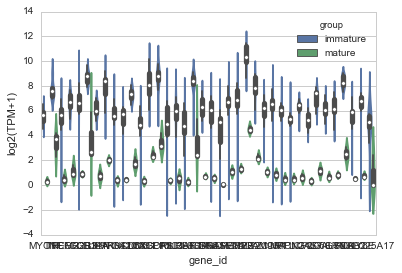

In [17]:
fig, ax = plt.subplots()
sns.violinplot(hue='group', y='log2(TPM+1)', x='gene_id', 
               data=singles_below_stringent_cutoff_tidy_metadata, kind='violin')
#cool!!!

We can make it bigger and wider:

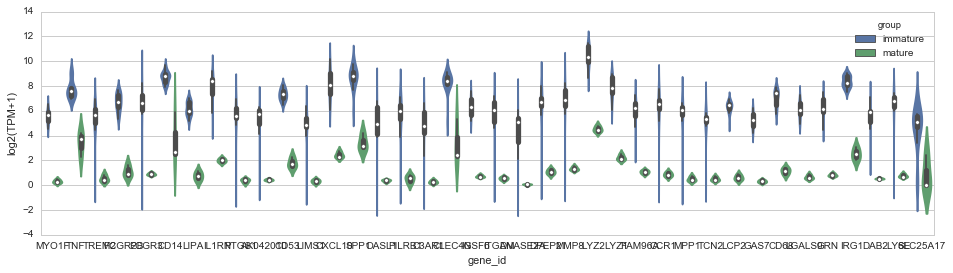

In [19]:
figwidth = 16
figheight = 4

fig, ax = plt.subplots(figsize=(figwidth, figheight)) # as opposed to .loc[r,c]
sns.violinplot(hue='group', y='log2(TPM+1)', x='gene_id', 
               data=singles_below_stringent_cutoff_tidy_metadata, kind='violin')

Hmm the genes are still hard to read .. maybe we can orient this horizontally? Notice that we have to swap the `figwidth` and `figheight`:

    figheight = 16
    figwidth = 4
    
**And** change the orientation to "h" (horizontal):

    orient='h'
    
**And** swap the `x` and `y`:

    x='log2(TPM+1)', y='gene_id'

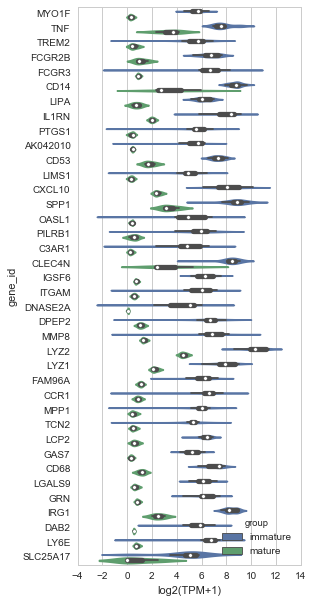

In [20]:
figheight = 10
figwidth = 4

fig, ax = plt.subplots(figsize=(figwidth, figheight))
sns.violinplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_below_stringent_cutoff_tidy_metadata)

My personal preference is I like ...

* `inner=None`: the inside to not have the mean and std dev info, but rather be empty
* `scale='width'`: the violinplot to be maximal width, even if it's very long. The default is for the whole area to be integrated to 1 but I think it's harder to read. i.e. 'area'
* `palette=palette`: Create a `palette` variable that we created earlier
* `hue_order=order`: make sure the sample are in the order that we want

In [19]:
print(singles_below_stringent_cutoff_tidy_metadata.shape)
singles_below_stringent_cutoff_tidy_metadata.head()

(684, 9)


,gene_id,sample_id,log2(TPM+1),phenotype,pooled,outlier,maturity,color,group
0,MYO1F,S1,5.533537,BDMC,False,False,immature,MediumTurquoise,immature
1,MYO1F,S2,6.088362,BDMC,False,False,immature,MediumTurquoise,immature
2,MYO1F,S3,5.719140,BDMC,False,False,immature,MediumTurquoise,immature
3,MYO1F,S4,5.678220,BDMC,False,False,immature,MediumTurquoise,immature
4,MYO1F,S5,5.383171,BDMC,False,False,immature,MediumTurquoise,immature


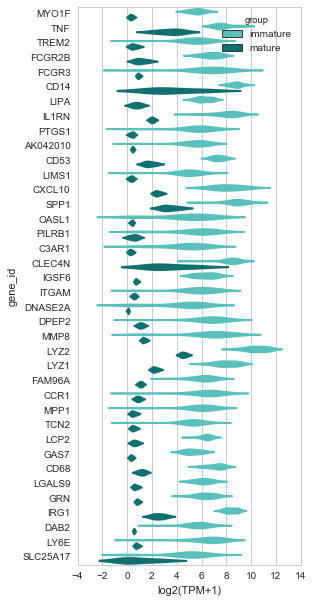

In [22]:
figheight = 10
figwidth = 4

# Create a palette and ordering for using with seaborn
palette = ['MediumTurquoise', 'Teal']
order = ['immature', 'mature']


fig, ax = plt.subplots(figsize=(figwidth, figheight))
sns.violinplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_below_stringent_cutoff_tidy_metadata, 
               inner=None, scale='width', hue_order=order, palette=palette, ax=ax)

Since we just have two categories, we could also do `split=True` to show two separate distributions (which looks cool *and* is useful - a rare treat!)

**Note: this only works if you have exactly two `hue` categories!**

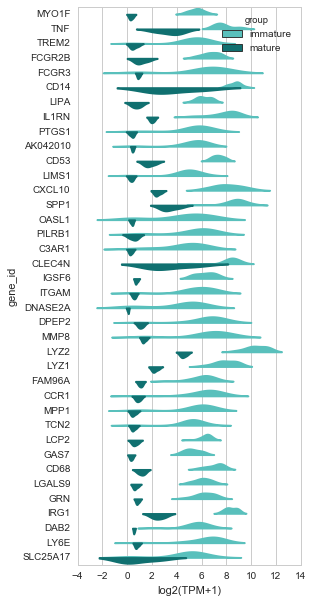

In [28]:
figheight = 10
figwidth = 4

# Create a palette and ordering for using with seaborn
palette = ['MediumTurquoise', 'Teal',]
order = ['immature', 'mature',]


fig, ax = plt.subplots(figsize=(figwidth, figheight))
sns.violinplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_below_stringent_cutoff_tidy_metadata, 
               inner=None, scale='width', hue_order=order, palette=palette, ax=ax, split=True)
#cut distributions in half and compare them side by side!!!
#all on one axis

I also like to add a `stripplot` which adds the individual cell observations

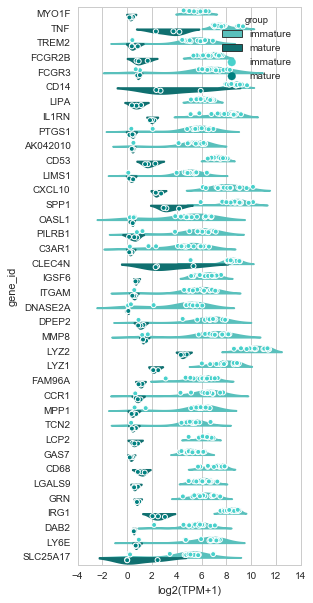

In [29]:
figheight = 10
figwidth = 4

# Create a palette and ordering for using with seaborn
palette = ['MediumTurquoise', 'Teal',]
order = ['immature', 'mature',]


fig, ax = plt.subplots(figsize=(figwidth, figheight))
sns.violinplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_below_stringent_cutoff_tidy_metadata, 
               inner=None, scale='width', hue_order=order, palette=palette, ax=ax, split=True)
sns.stripplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_below_stringent_cutoff_tidy_metadata,
               hue_order=order, palette=palette, ax=ax, split=True, 
              edgecolor='white', linewidth=1, jitter=True)
#show individual samples on top

### Facetgrids

Facetgrids are another way that you can make violinplots, and are very useful when you have many genes and especially many categories (e.g. clusters) that you want to plot.

We can save the figure with `facetgrid.savefig`

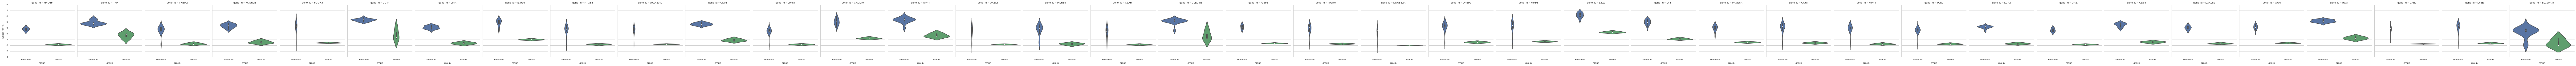

In [30]:
facetgrid = sns.factorplot(x='group', y='log2(TPM+1)', col='gene_id',
                           data=singles_below_stringent_cutoff_tidy_metadata, kind='violin')
facetgrid.savefig('shalek2013_singles_below_stringent_cutoff_violins.pdf')

Yikes, that's so wide! Let's wrap the columns around after they reach length 4 with:

    col_wrap=4

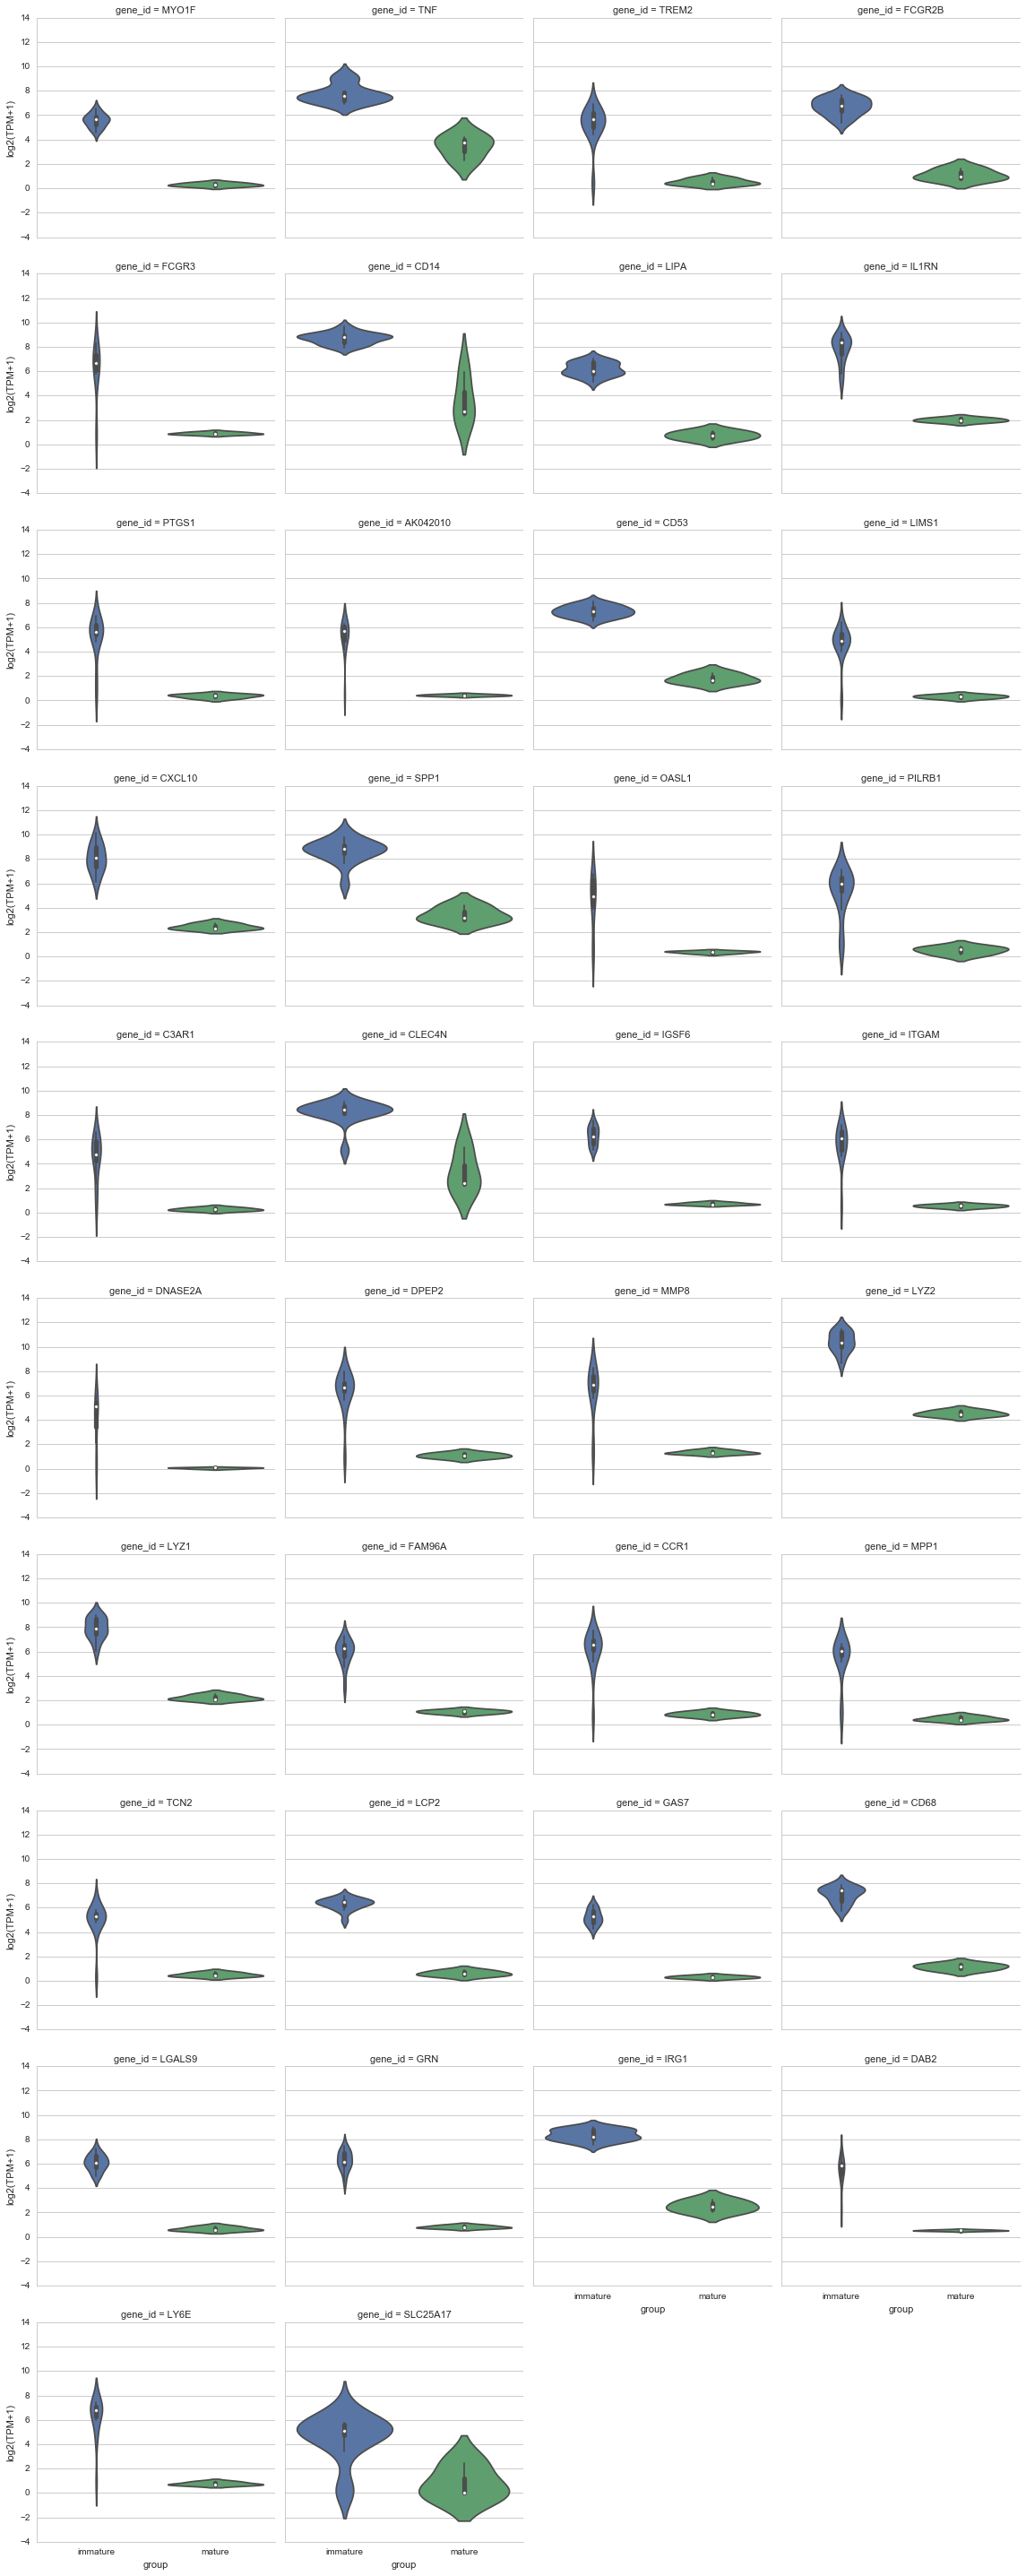

In [31]:
facetgrid = sns.factorplot(x='group', y='log2(TPM+1)', col='gene_id', col_wrap=4,
                           data=singles_below_stringent_cutoff_tidy_metadata, kind='violin')
facetgrid.savefig('shalek2013_singles_below_stringent_cutoff_violins_col_wrapped.pdf')

Let's pass the same parameters that we used for the violins before with:

    inner=None, scale='width', palette=palette, order=order

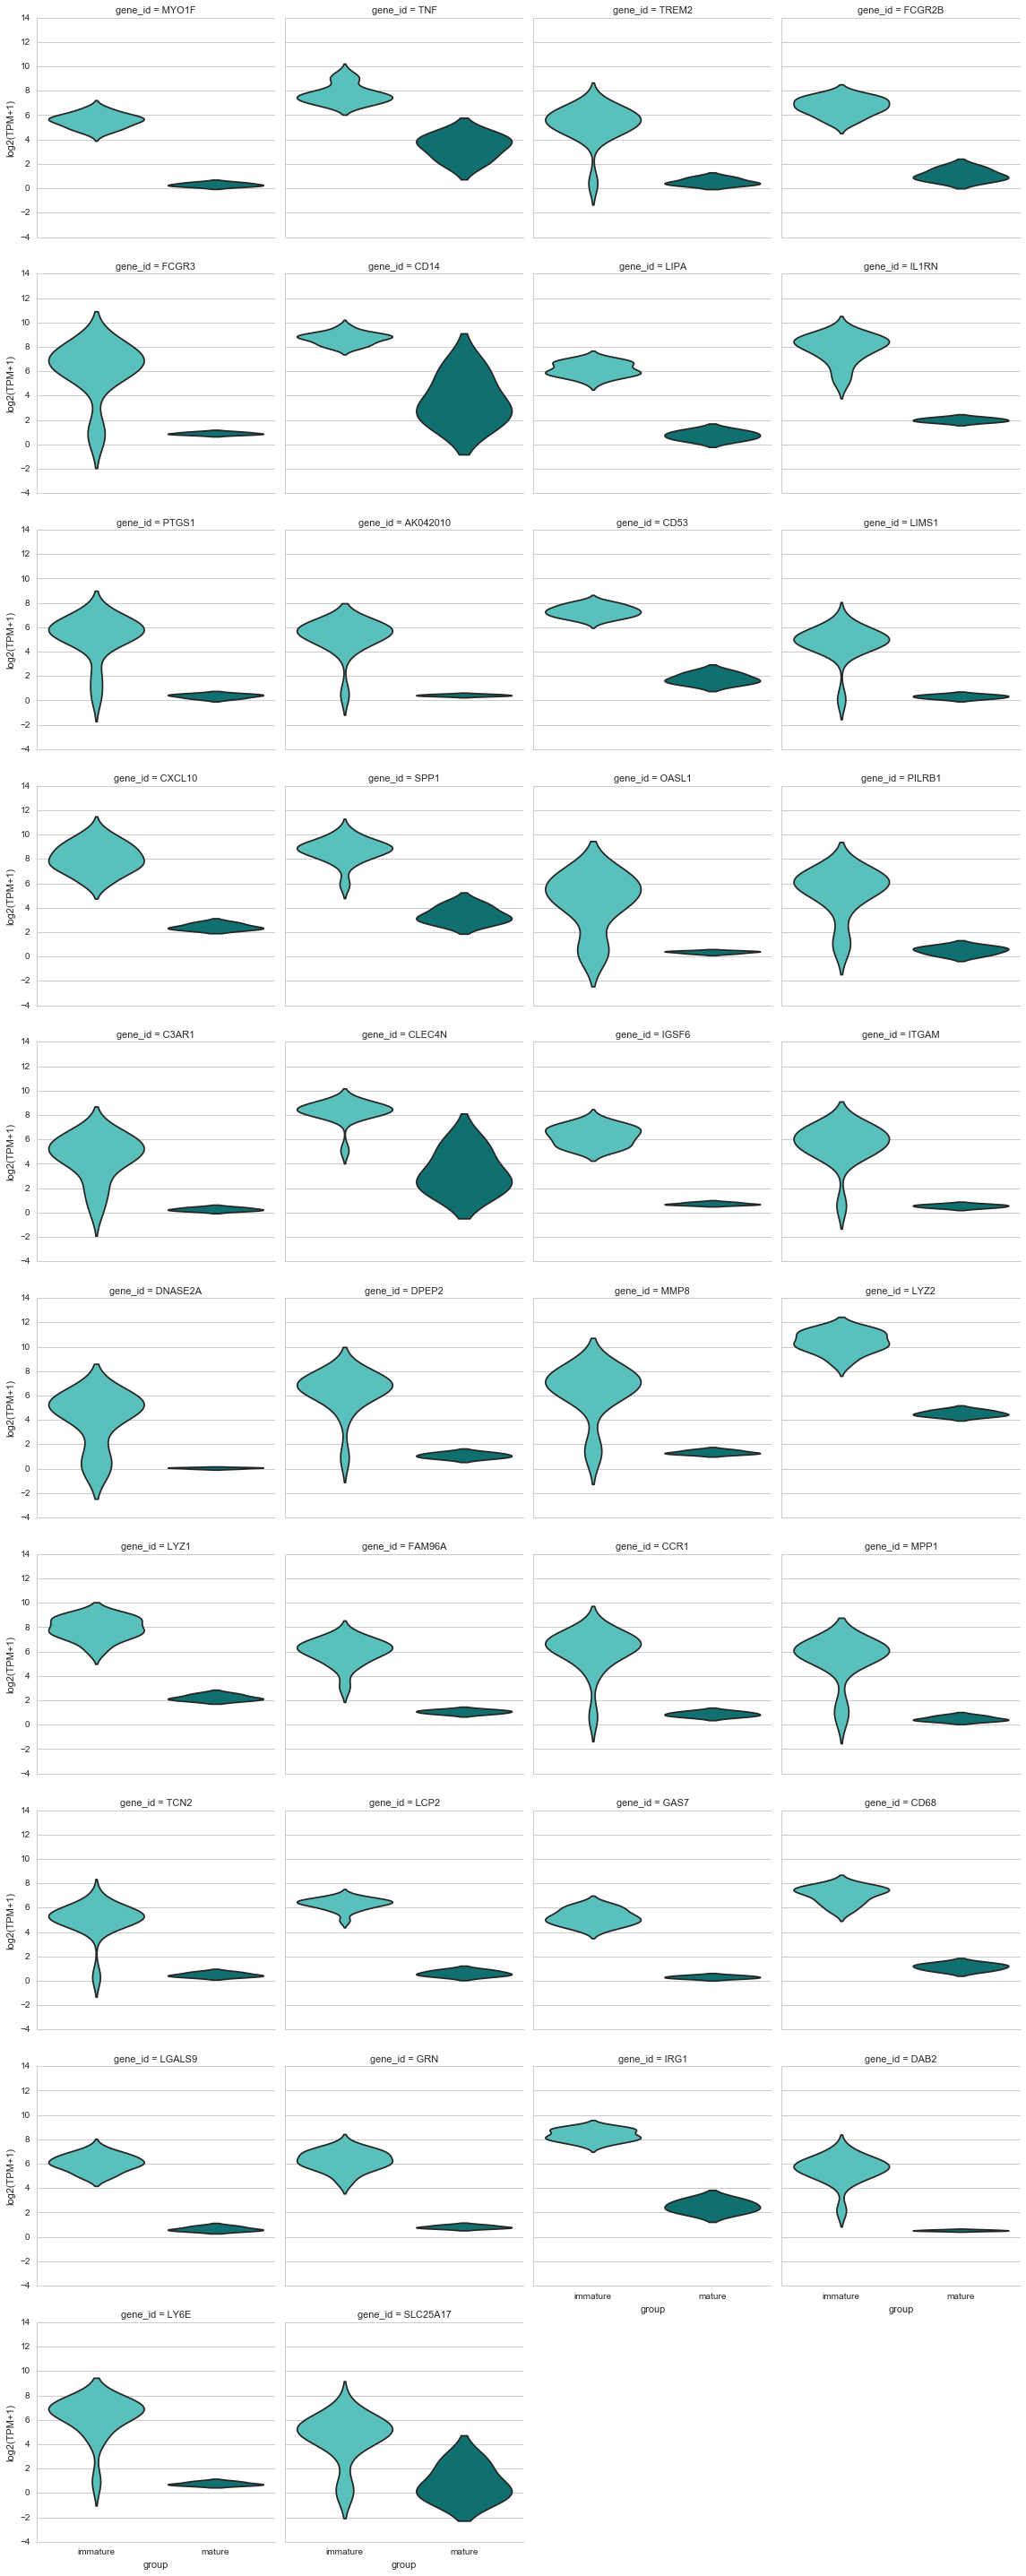

In [33]:
facetgrid = sns.factorplot(x='group', y='log2(TPM+1)', col='gene_id', col_wrap=4,
                           data=singles_below_stringent_cutoff_tidy_metadata, kind='violin', 
                           inner=None, scale='width', palette=palette, order=order)
facetgrid.savefig('shalek2013_singles_below_stringent_cutoff_violins_palette.pdf')

We can also add `stripplot`!! We'll send each facet (individual axes) the data it needs with `map_dataframe`

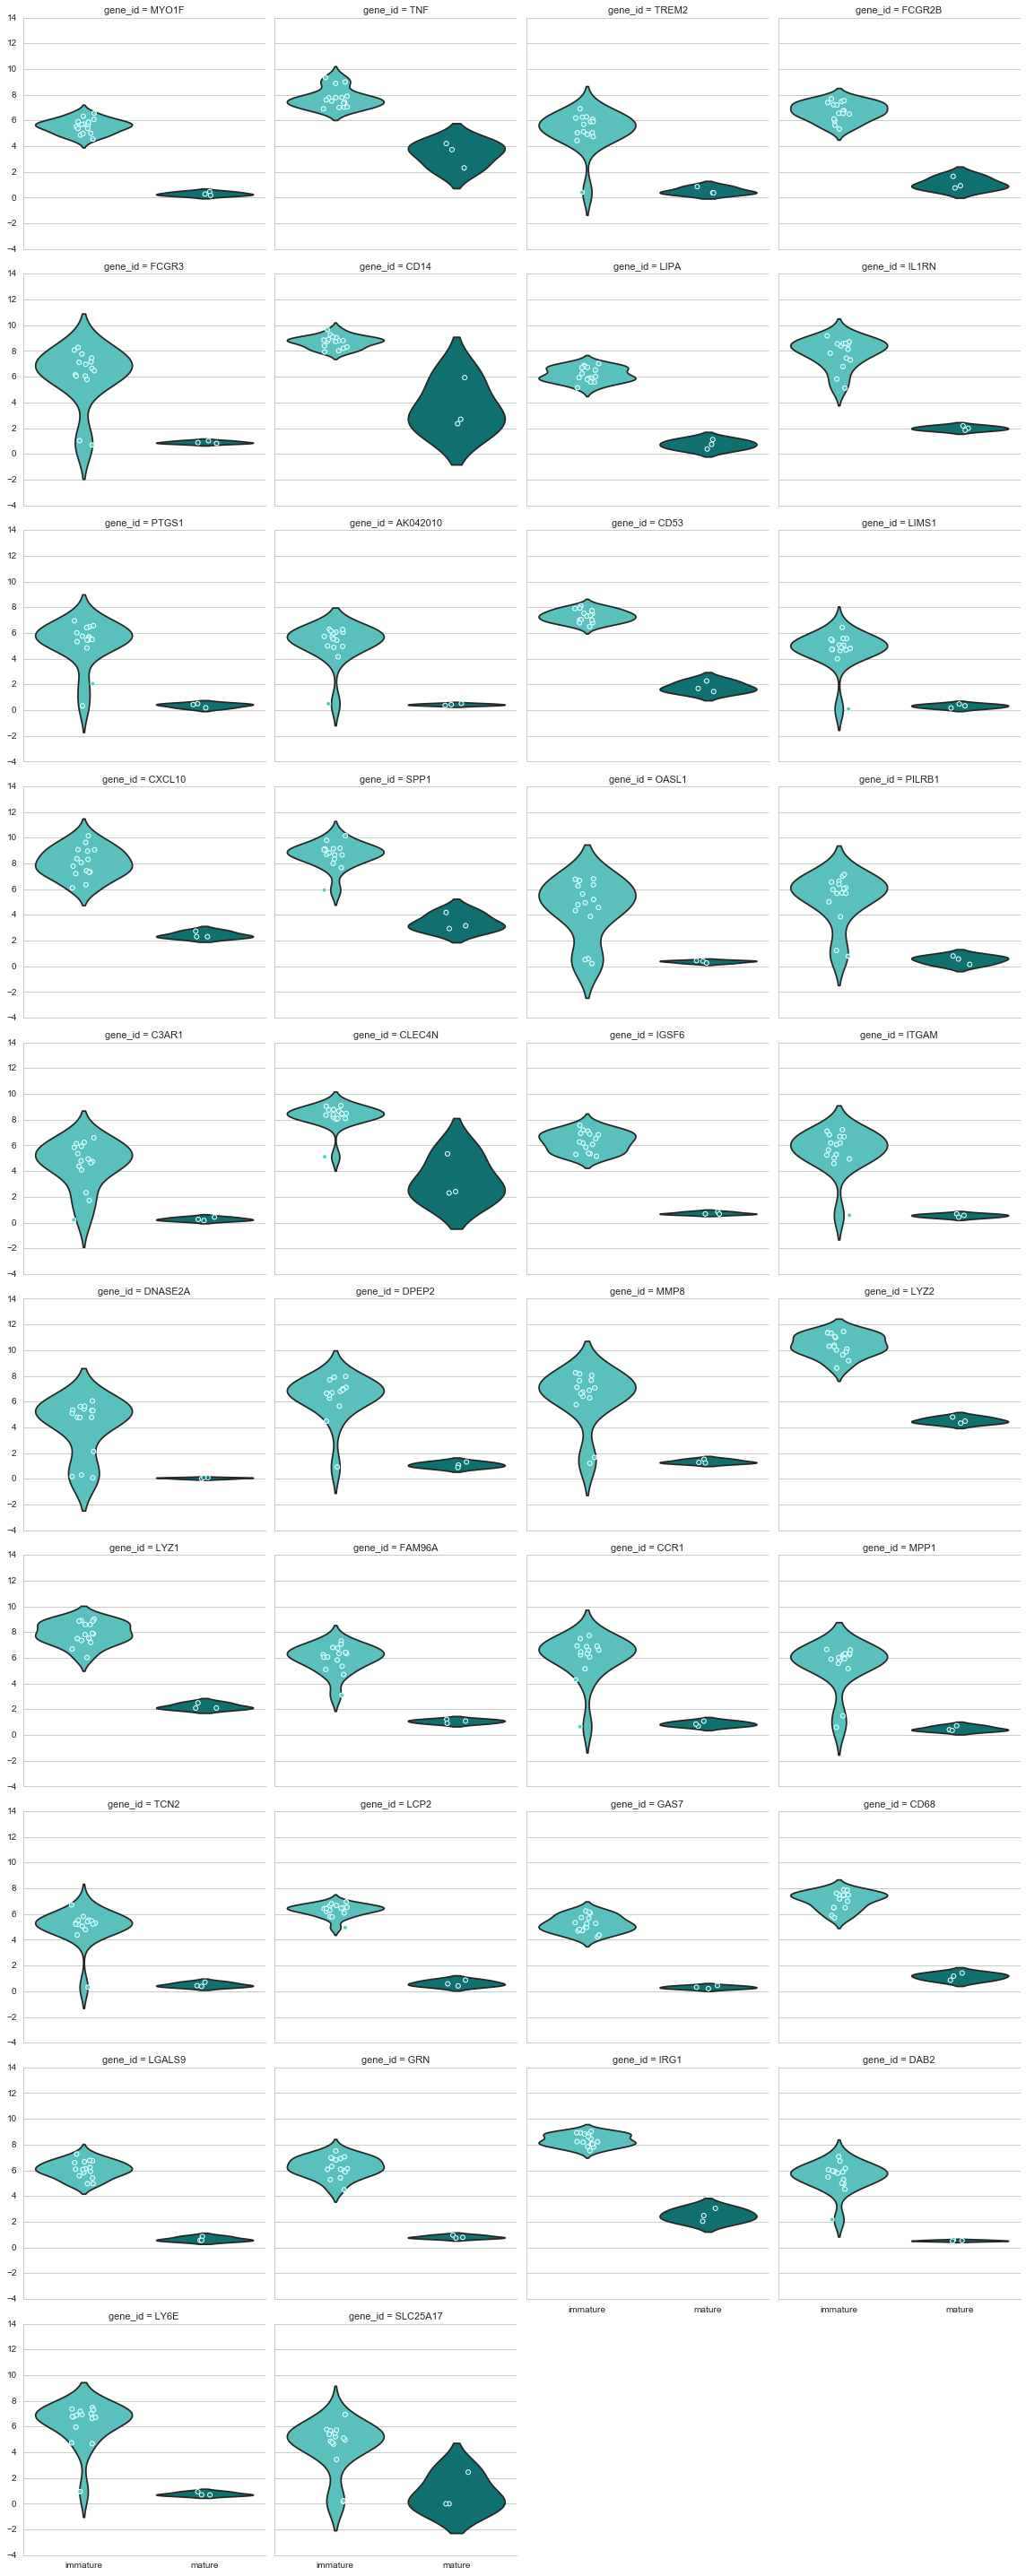

In [34]:
facetgrid = sns.factorplot(x='group', y='log2(TPM+1)', col='gene_id', col_wrap=4,
                            data=singles_below_stringent_cutoff_tidy_metadata, kind='violin', 
                           inner=None, scale='width', palette=palette, order=order,)
facetgrid.map_dataframe(sns.stripplot, x='group', y='log2(TPM+1)', palette=palette, 
                        order=order, jitter=True, edgecolor='white', linewidth=1)
facetgrid.savefig('shalek2013_singles_below_stringent_cutoff_violins_stripplot.pdf')

### Exercise

1. Make a horizontally oriented, split `violinplot`+`stripplot` of the top-enriched genes ABOVE the upper cutoff.
2. Make a factorplot of `violinplot`+`stripplot` of the top-enriched genes ABOVE the upper cutoff.
3. Change the palette colors to [colors of your choice](https://en.wikipedia.org/wiki/Web_colors#X11_color_names) and swap the order to be mature first, immature second

Use as many code cells as you need.

In [50]:
# YOUR CODE HERE
above_stringent_cutoff = coefficients[coefficients > (coefficients.mean() + 3*coefficients.std())]
print(above_stringent_cutoff.shape)
above_stringent_cutoff.head()

(24,)


ZEB1        0.000765
AW112010    0.000889
RFK         0.000771
PCGF5       0.000737
PSEN2       0.000802
dtype: float64

In [51]:
# YOUR CODE HERE
singles_above_stringent_cutoff = singles[above_stringent_cutoff.index]
print(singles_above_stringent_cutoff.shape)
singles_above_stringent_cutoff.head()

(18, 24)


,ZEB1,AW112010,RFK,PCGF5,PSEN2,AK041746,CD82,PROCR,GNB4,GLIPR2,...,TMEM123,STK17B,CCR7,FAM49A,ARID4A,NET1,SERPINB9,PDE4D,KTELC1,TMEM39A
S1,0.065900,0.000000,0.000000,0.000000,1.001053,0.365463,0.293740,0.000000,0.000000,4.164981,...,0.231390,0.000000,0.624016,1.242920,0.138457,0.054363,0.151851,0.000000,3.777881,3.497191
S2,0.101811,0.618944,0.000000,0.000000,0.241511,5.338293,6.100757,0.185019,0.101664,5.385857,...,0.142868,0.000000,0.794663,0.029806,0.626460,0.123767,0.262953,0.124628,0.154876,0.363518
S3,0.000000,6.813666,0.654051,1.005652,0.053673,4.778786,0.274439,4.749761,0.036997,0.311246,...,0.307954,0.118372,0.558187,3.821152,0.077835,0.030477,0.166924,0.170988,0.303040,2.136539
S4,0.108364,4.605141,0.050465,0.000000,4.646006,0.474172,5.329434,0.162415,0.045432,0.456822,...,0.043512,0.038007,0.840358,0.025957,1.965856,0.108386,0.202128,0.108924,0.177319,0.410464
S5,0.037227,4.448688,0.000000,0.069086,0.053916,0.220468,3.524275,3.297987,0.000000,0.273400,...,0.069969,3.719637,0.393915,2.263501,0.346061,0.089192,0.167672,4.921130,0.112037,0.207874


In [55]:
# YOUR CODE HERE
singles_above_stringent_cutoff_unstacked = singles_above_stringent_cutoff.unstack() #awesome!!!
print(singles_above_stringent_cutoff_unstacked.shape)
singles_above_stringent_cutoff_unstacked.head()
#Series as no lines dividing into table - v long tall list
# singles_below_stringent_cutoff_unstacked.tail()

(432,)


ZEB1  S1    0.065900
      S2    0.101811
      S3    0.000000
      S4    0.108364
      S5    0.037227
dtype: float64

In [56]:
singles_above_stringent_cutoff_reset_index = singles_above_stringent_cutoff_unstacked.reset_index()
print(singles_above_stringent_cutoff_reset_index.shape)
singles_above_stringent_cutoff_reset_index.head()
#with column of multiple unique values - can use groupby!! Can have multi level row name!!!
#reset_index makes every column in series an actual column in dataframe - level_0 e.g. gene ID, level_1 e.g. cell type

(432, 3)


,level_0,level_1,0
0,ZEB1,S1,0.065900
1,ZEB1,S2,0.101811
2,ZEB1,S3,0.000000
3,ZEB1,S4,0.108364
4,ZEB1,S5,0.037227


In [57]:
singles_above_stringent_cutoff_tidy = singles_above_stringent_cutoff_reset_index.rename(
    columns={'level_0': 'gene_id', 'level_1': 'sample_id', 0:'log2(TPM+1)'}) #renamed data frame col names
print(singles_above_stringent_cutoff_tidy.shape)
singles_above_stringent_cutoff_tidy.head()

(432, 3)


,gene_id,sample_id,log2(TPM+1)
0,ZEB1,S1,0.065900
1,ZEB1,S2,0.101811
2,ZEB1,S3,0.000000
3,ZEB1,S4,0.108364
4,ZEB1,S5,0.037227


In [58]:
singles_above_stringent_cutoff_tidy_metadata = singles_above_stringent_cutoff_tidy.join(metadata, on='sample_id') ## :)
print(singles_above_stringent_cutoff_tidy_metadata.shape) # duplicate info of gene sample and TPM data - ok - easy to plt later
singles_above_stringent_cutoff_tidy_metadata.head()

(432, 9)


,gene_id,sample_id,log2(TPM+1),phenotype,pooled,outlier,maturity,color,group
0,ZEB1,S1,0.065900,BDMC,False,False,immature,MediumTurquoise,immature
1,ZEB1,S2,0.101811,BDMC,False,False,immature,MediumTurquoise,immature
2,ZEB1,S3,0.000000,BDMC,False,False,immature,MediumTurquoise,immature
3,ZEB1,S4,0.108364,BDMC,False,False,immature,MediumTurquoise,immature
4,ZEB1,S5,0.037227,BDMC,False,False,immature,MediumTurquoise,immature


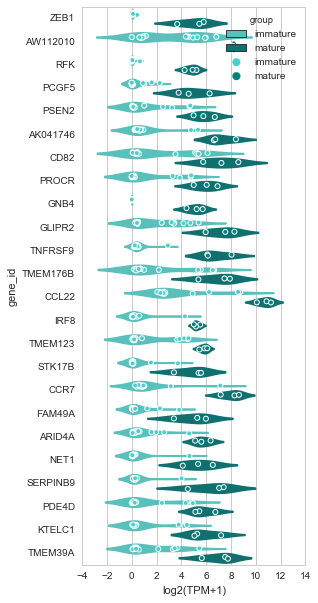

In [61]:
figheight = 10
figwidth = 4

# Create a palette and ordering for using with seaborn
palette = ['MediumTurquoise', 'Teal',]
order = ['immature', 'mature',]


fig, ax = plt.subplots(figsize=(figwidth, figheight))
sns.violinplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_above_stringent_cutoff_tidy_metadata, 
               inner=None, scale='width', hue_order=order, palette=palette, ax=ax, split=False)
sns.stripplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_above_stringent_cutoff_tidy_metadata,
               hue_order=order, palette=palette, ax=ax, split=True, 
              edgecolor='white', linewidth=1, jitter=True)
#cut distributions in half and compare them side by side!!!
#all on one axis

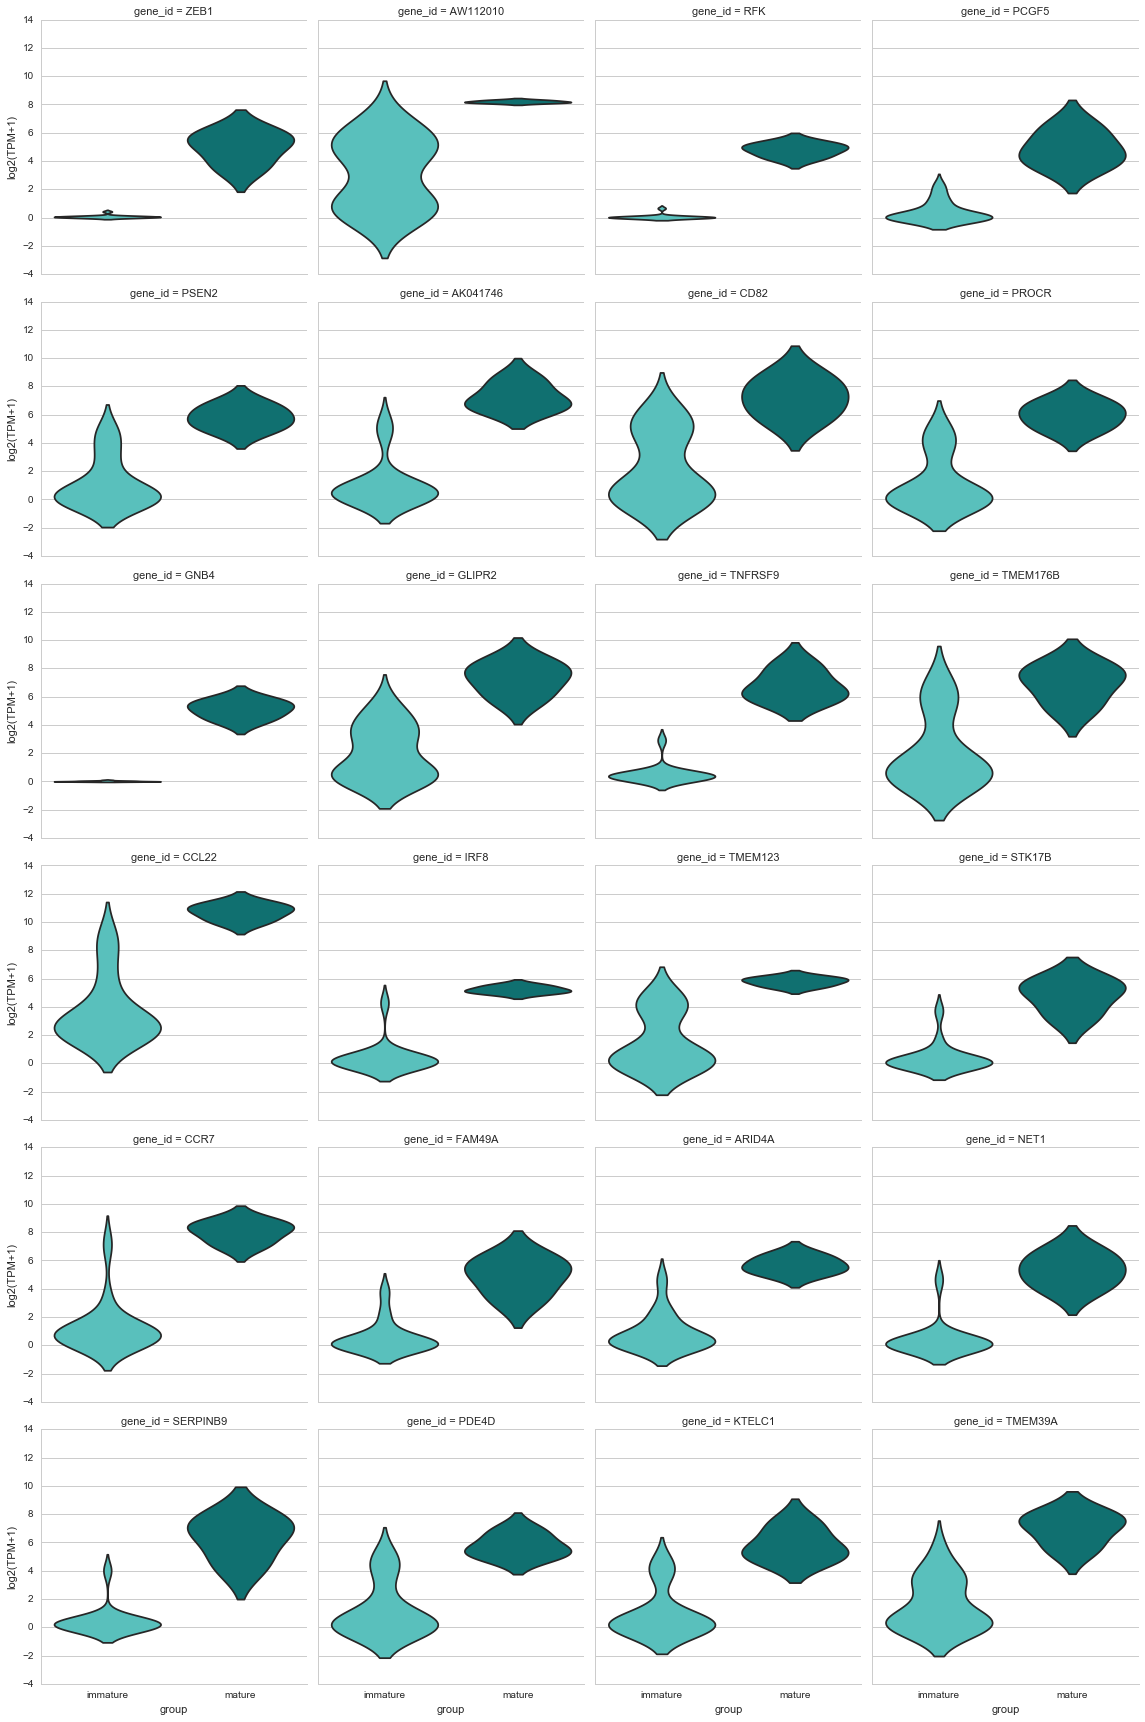

In [62]:
facetgrid = sns.factorplot(x='group', y='log2(TPM+1)', col='gene_id', col_wrap=4,
                           data=singles_above_stringent_cutoff_tidy_metadata, kind='violin', 
                           inner=None, scale='width', palette=palette, order=order)
facetgrid.savefig('shalek2013_singles_above_stringent_cutoff_violins_palette.pdf')

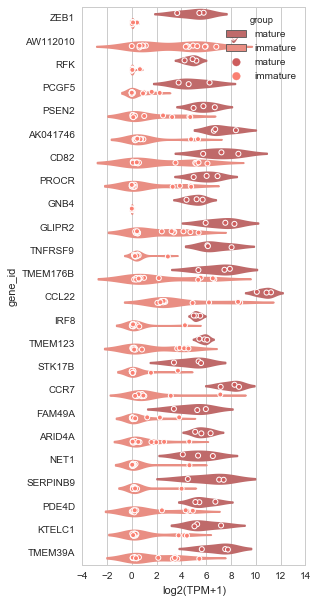

In [67]:
figheight = 10
figwidth = 4

# Create a palette and ordering for using with seaborn
palette = ['IndianRed', 'Salmon',]
order = ['mature', 'immature',]


fig, ax = plt.subplots(figsize=(figwidth, figheight))
sns.violinplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_above_stringent_cutoff_tidy_metadata, 
               inner=None, scale='width', hue_order=order, palette=palette, ax=ax, split=False)
sns.stripplot(hue='group', x='log2(TPM+1)', y='gene_id', orient='h',
               data=singles_above_stringent_cutoff_tidy_metadata,
               hue_order=order, palette=palette, ax=ax, split=True, 
              edgecolor='white', linewidth=1, jitter=True)
#cut distributions in half and compare them side by side!!!
#all on one axis

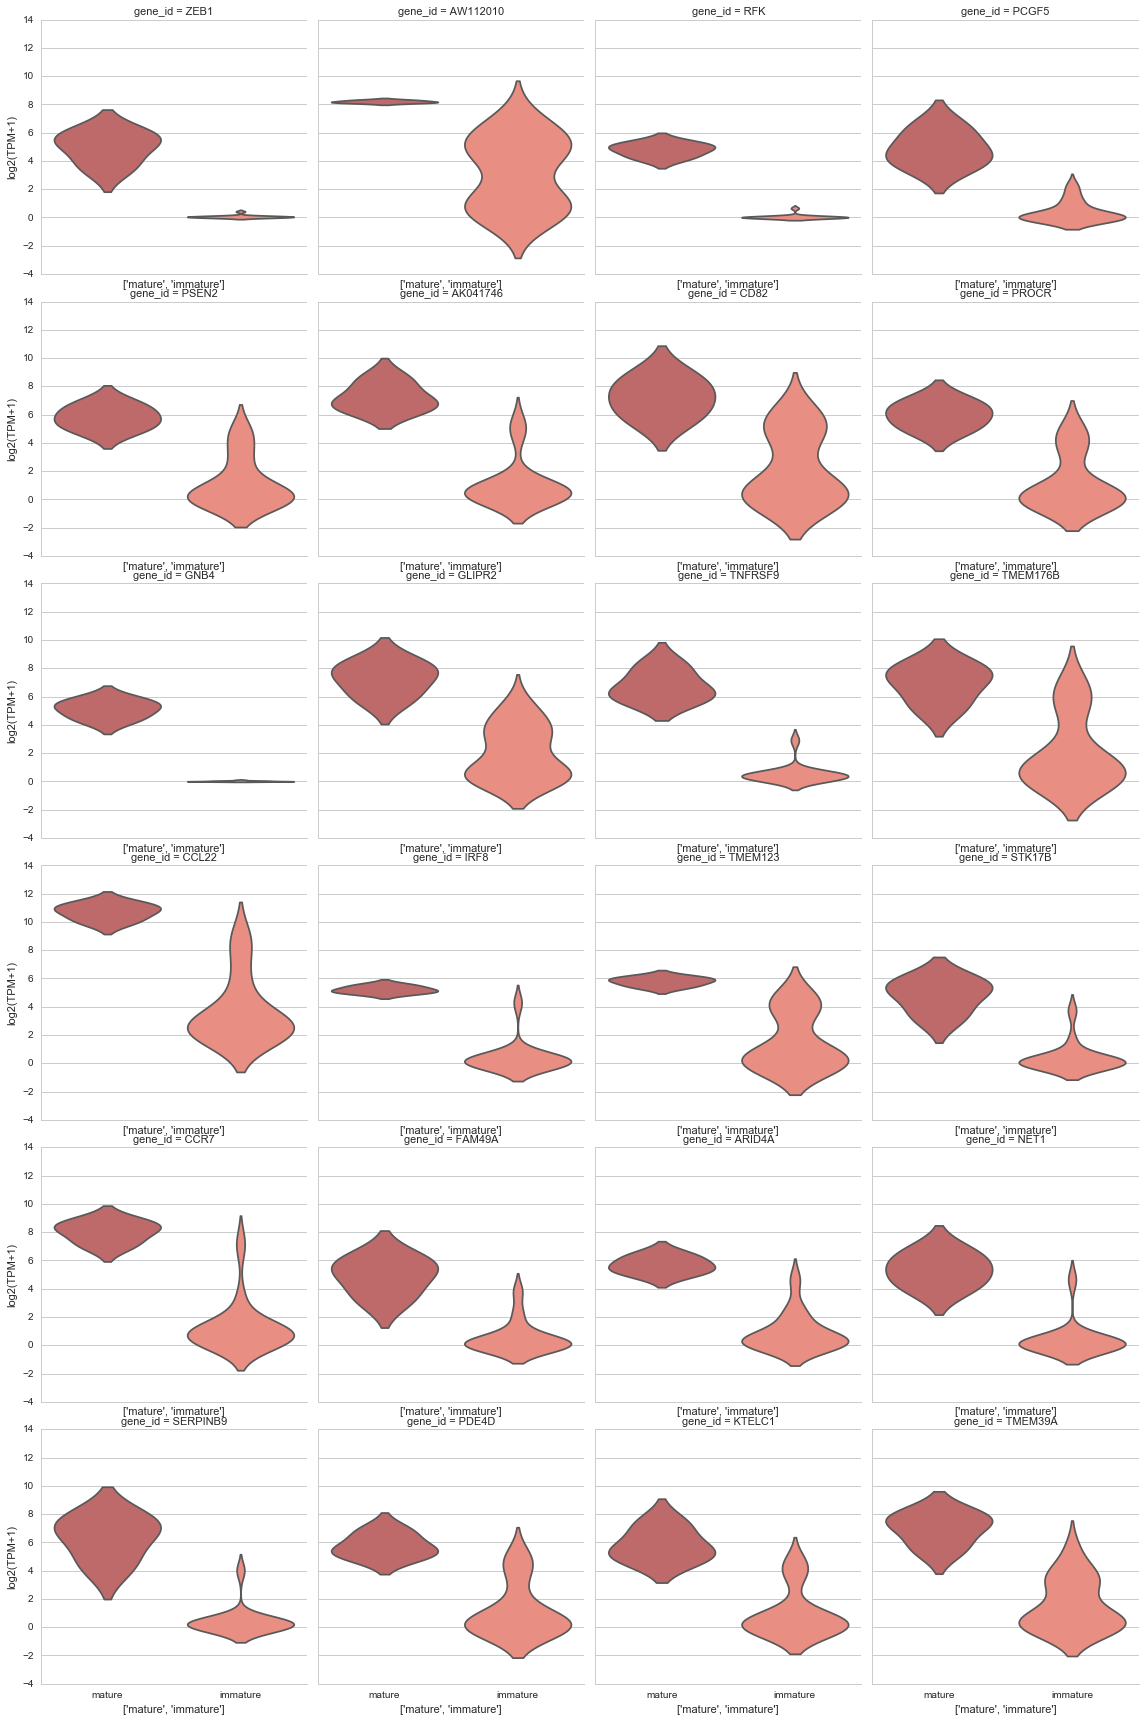

In [76]:
facetgrid = sns.factorplot(x='group', y='log2(TPM+1)', col='gene_id', col_wrap=4,
                           data=singles_above_stringent_cutoff_tidy_metadata, kind='violin', 
                           inner=None, scale='width', palette=palette, order=order)
for ax in facetgrid.axes.flat:
    ax.set_xlabel(order)
facetgrid.savefig('shalek2013_singles_above_stringent_cutoff_violins_palette2.pdf')
#cf matplot lib seaborn smooths raw data around curve rather than matplotlib


In [77]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [ ]:
#code is read far more often than it is written
#one way opposite of Perl
#https://www.python.org/dev/peps/pep-0008/#prescriptive-naming-conventions
#variable names prefer lower case with underscores